In [11]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from utilities import *

In [12]:
# 加载euro_road数据集
df1 = pd.read_csv("../data/euro_road.csv")
road_g = nx.from_pandas_edgelist(df1, "source", "target", create_using=nx.Graph())

# 加载open_flight数据集
df2 = pd.read_csv("../data/open_flight.csv")
flight_g = nx.from_pandas_edgelist(df2, "source", "target", create_using=nx.Graph())

print("road_graph nodes: %d edges: %d" % (len(road_g.nodes), len(road_g.edges)))
print("flight_graph nodes: %d edges: %d" % (len(flight_g.nodes), len(flight_g.edges)))

road_graph nodes: 1174 edges: 1417
flight_graph nodes: 3425 edges: 19257


In [13]:
# 计算度分布
def get_pk(G):
    all_k = [G.degree[i] for i in G.nodes]  # 获得每个节点的度
    k = list(set(all_k))  # 去掉重复的度值
    N = len(G.nodes)  # 节点数目

    pk = []  # 度分布
    sorted_k = sorted(k)
    # 对于每个度值，统计节点所占比例，即该度值的概率
    for ki in sorted_k:
        cnt = 0
        for i in G.nodes:
            if G.degree[i] == ki:
                cnt += 1
        pk.append(cnt / N)
    
    return sorted_k, pk

In [14]:
k1, pk1 = get_pk(road_g)
k2, pk2 = get_pk(flight_g)

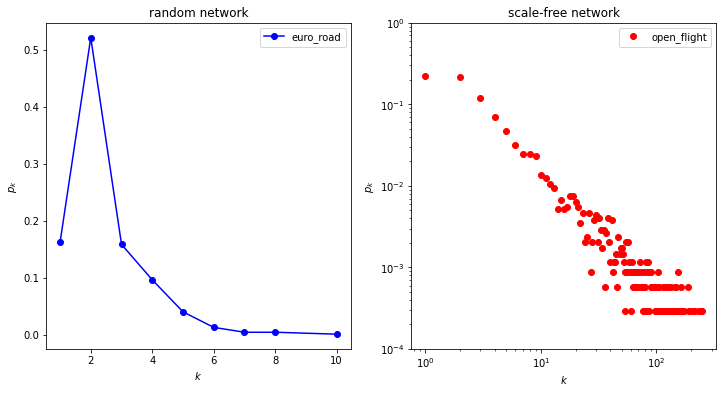

In [15]:
plt.figure(figsize=(12, 6))

plt.subplot(121)
plt.plot(k1, pk1, "bo-", label="euro_road")
plt.legend(loc=0)
plt.xlabel("$k$")
plt.ylabel("$p_k$")
plt.title("random network")

plt.subplot(122)
plt.plot(k2, pk2, "ro", label="open_flight")
plt.legend(loc=0)
plt.xlabel("$k$")
plt.ylabel("$p_k$")
plt.title("scale-free network")
plt.ylim(1e-4, 1)
plt.xscale("log")
plt.yscale("log")

plt.show()

In [16]:
import powerlaw

d = np.array((nx.degree(flight_g)))[:, 1]  # 所有节点的度值
print(max(d))

fit = powerlaw.Fit(d)  # 拟合度分布
print(fit)
print("k_min: ", fit.power_law.xmin)  # 最小度值，即排除掉小度节点后进行幂律拟合
print("gamma: ", fit.power_law.alpha)  # 度指数

248
k_min:  2.0
gamma:  1.9028919860606162


Calculating best minimal value for power law fit
e:\Miniconda3\envs\pytorch\lib\site-packages\powerlaw.py:699: RuntimeWarning: invalid value encountered in true_divide
  (CDF_diff**2) /


<AxesSubplot:>

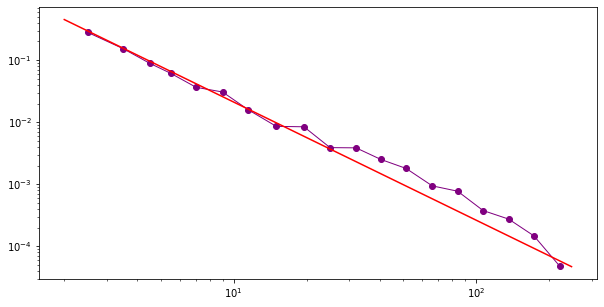

In [17]:
plt.figure(figsize=(10, 5))
fig = fit.plot_pdf(marker="o", color="purple", linewidth=1)  # 绘制真实度分布
fit.power_law.plot_pdf(color="red", linestyle="-", ax=fig)  # 绘制幂律拟合曲线

In [18]:
# 生成符合幂律的度序列
from networkx.utils import powerlaw_sequence

n, gamma = 5000, 2.1
degree_seq = powerlaw_sequence(n, gamma)  # 生成度序列
int_deg = [int(d) for d in degree_seq]  # 取整

# 用于配置模型生成网络的度序列的度总和必须是偶数！
while sum(int_deg) % 2 != 0:
    degree_seq = powerlaw_sequence(n, gamma)
    int_deg = [int(d) for d in degree_seq]

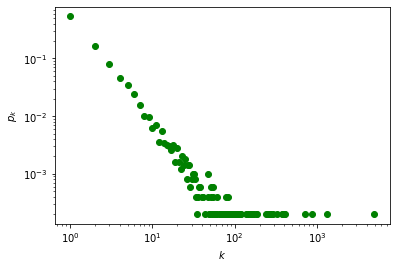

In [19]:
# 利用配置模型生成网络
g = nx.configuration_model(int_deg)

k, pk = get_pdf(g)  # 计算度分布

plt.figure(figsize=(6, 4))
plt.plot(k, pk, "go")
plt.xlabel("$k$")
plt.ylabel("$p_k$")
plt.xscale("log")
plt.yscale("log")

In [30]:
# 生成度保持的随机化网络
N = len(flight_g.nodes)
E = len(flight_g.edges)
flight_g2 = flight_g.copy()
nx.double_edge_swap(flight_g2, nswap=E, max_tries=5*E)
flight_g3 = nx.gnm_random_graph(N, E)
print("原网络: ", nx.average_clustering(flight_g))
print("度保持的随机化网络: ", nx.average_clustering(flight_g2))
print("完全随机网络: ", nx.average_clustering(flight_g3))

原网络:  0.4870933566129556
度保持的随机化网络:  0.07997961891954508
完全随机网络:  0.0027079217469949063


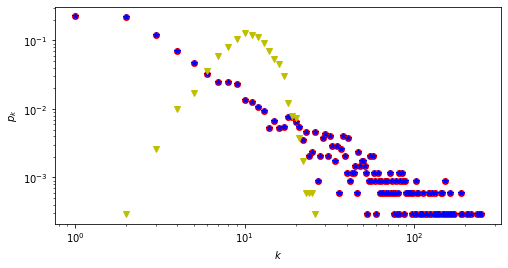

In [44]:
k1, pk1 = get_pdf(flight_g)
k2, pk2 = get_pdf(flight_g2)
k3, pk3 = get_pdf(flight_g3)

plt.figure(figsize=(8,4))
plt.plot(k1, pk1, "ro")
plt.plot(k2, pk2, "b*")
plt.plot(k3, pk3, "yv")
plt.xlabel("$k$")
plt.ylabel("$p_k$")
plt.xscale("log")
plt.yscale("log")

<AxesSubplot:>

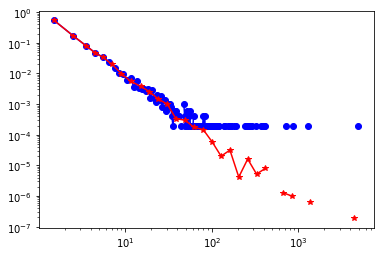

In [50]:
import powerlaw
# 对数坐标，线性分箱
powerlaw.plot_pdf(degree_seq, linear_bins=True, color="blue", marker="o")
# 对数坐标，对数分箱
powerlaw.plot_pdf(degree_seq, linear_bins=False, color="red", marker="*")

<AxesSubplot:>

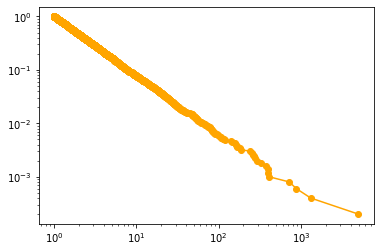

In [53]:
# 对数坐标，累积分布
powerlaw.plot_ccdf(degree_seq, color="orange", marker="o")